# 线性回归的从零开始实现

在了解线性回归的关键思想之后，我们可以开始通过代码来动手实现线性回归了。
在这一节中，我们将从零开始实现整个方法，
包括数据流水线、模型、损失函数和小批量随机梯度下降优化器。
虽然现代的深度学习框架几乎可以自动化地进行所有这些工作，但从零开始实现可以确保我们真正知道自己在做什么。
同时，了解更细致的工作原理将方便我们自定义模型、自定义层或自定义损失函数。
在这一节中，我们将只使用张量和自动求导。
在之后的章节中，我们会充分利用深度学习框架的优势，介绍更简洁的实现方式。

In [1]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

## 生成数据集

为了简单起见，我们将**根据带有噪声的线性模型构造一个人造数据集。**
我们的任务是使用这个有限样本的数据集来恢复这个模型的参数。
我们将使用低维数据，这样可以很容易地将其可视化。
在下面的代码中，我们生成一个包含1000个样本的数据集，
每个样本包含从标准正态分布中采样的2个特征。
我们的合成数据集是一个矩阵$\mathbf{X}\in \mathbb{R}^{1000 \times 2}$。

我们使用线性模型参数$\mathbf{w} = [2, -3.4]^\top$、$b = 42$
和噪声项$\epsilon$生成数据集及其标签：

$$\mathbf{y}= \mathbf{X} \mathbf{w} + b + \mathbf\epsilon$$

$\epsilon$可以视为模型预测和标签时的潜在观测误差。
在这里我们认为标准假设成立，即$\epsilon$服从均值为0的正态分布。
为了简化问题，我们将标准差设为0.01。
下面的代码生成合成数据集。

In [3]:
def synthetic_data(w, b, num_examples):  #@save
    """生成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))  # num_examples 行，len(w) 列 （X的维度：n * p）
    y = torch.matmul(X, w) + b  # 这里的 y 和常规的数学直觉不同，是一个一维的行向量，所以需要 reshape 转为列向量
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))  # -1 表示自动计算维度0（行）的个数；1 表示 reshape 为 1 列（维度1）

注意 torch.matmul(X, w) 从数学角度看应返回一个 n\*1 的矩阵（列向量），但实际返回的是一个 n 维的（行）向量，所以需要通过 reshape 转换为 n*1 的矩阵（列向量）。

reshape((-1, 1)) 表示将一维张量转化为两维；抓换后列数为1，行数-1表示自动适应计算。

下面为效果验证展示。

In [9]:
w = torch.tensor([2, -3.4])
X = torch.normal(0, 1, (5, len(w))) 
y = torch.matmul(X, w)  # 这里的 y 和常规的数学直觉不同，是一个一维的行向量，所以需要 reshape 转为列向量（二维矩阵）
y, y.shape, y.reshape((-1, 1)), y.reshape((-1, 1)).shape

(tensor([ 5.2470e-04,  2.2783e+00,  1.9238e+00,  1.9998e-01, -1.4404e+00]),
 torch.Size([5]),
 tensor([[ 5.2470e-04],
         [ 2.2783e+00],
         [ 1.9238e+00],
         [ 1.9998e-01],
         [-1.4404e+00]]),
 torch.Size([5, 1]))

生成数据。

In [11]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

注意，`features`中的每一行都包含一个二维数据样本，
`labels`中的每一行都包含一维标签值（一个标量）。

In [23]:
# features[0] 效果等价于 features[0,:] or features[0,]
print('features:', features[0], '\nlabel:', labels[0])

features: tensor([ 1.9304, -0.1804]) 
label: tensor([8.6770])


通过生成第二个特征`features[:, 1]`和`labels`的散点图，
可以直观观察到两者之间的线性关系。


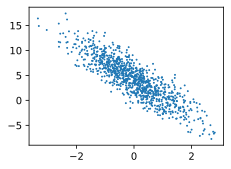

In [29]:
d2l.set_figsize()
# detach 是从计算图中分离张量的一种方法，共享数据但不共享计算图
# detach 后再转为 array，确保这些张量不会影响后续的反向传播计算（因为关于张量的每一个操作都会被计算图所记录）
d2l.plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1);
# d2l.plt.show() 的作用等价于上文结尾的 ; 。可以抑制输出图形对象的内存地址（如<matplotlib.collections.PathCollection at 0x16dc05880>）

## 读取数据集（小批量随机）

回想一下，训练模型时要对数据集进行遍历，每次抽取一小批量样本，并使用它们来更新我们的模型。
由于这个过程是训练机器学习算法的基础，所以有必要定义一个函数，
该函数能打乱数据集中的样本并以小批量方式获取数据。

在下面的代码中，我们**定义一个`data_iter`函数，
该函数接收批量大小、特征矩阵和标签向量作为输入，生成大小为`batch_size`的小批量**。
每个小批量包含一组特征和标签。

**注：yield 让函数可以暂停并保存其状态，在后续调用时继续执行，适合在需要多次返回值的场景下使用。**

In [37]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)  # shuffle 是打乱原列表，不是生成新列表
    for i in range(0, num_examples, batch_size):  # batch_size 代表批量中元素的个数，以它作为步长，循环次数即是 batch 的数量
        batch_indices = torch.tensor(indices[i: min(i + batch_size, num_examples)])  # 每个 batch 中包含的元素（batch_size 个）
        yield features[batch_indices], labels[batch_indices]
        # return 只会返回一次值，一旦执行就会终止函数；yield 则可多次返回，适用于需要多次返回值的场景（循环）使用

yield 让函数可以暂停并保存其状态，在后续调用时继续执行，适合在需要多次返回值的场景下使用。

**所以yield 返回的是一个生成器（generator），逐步生成结果，需要 for 循环来取得每一次调用该函数产生的值。**

In [38]:
data_iter(2, features, labels)

<generator object data_iter at 0x16daba350>

通常，我们利用GPU并行运算的优势，处理合理大小的“小批量”。
每个样本都可以并行地进行模型计算，且每个样本损失函数的梯度也可以被并行计算。
GPU可以在同时处理几百个样本时，所花费的时间不比处理一个样本时多太多。

我们直观感受一下小批量运算：读取第一个小批量数据样本并打印。
每个批量的特征维度显示批量大小和输入特征数。
同样的，批量的标签形状与`batch_size`相等。

In [39]:
batch_size = 10

# 因为 yield 得到的是一个生成器，故需要循环来得到每次的结果
for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break  # break 来展示一组的输出效果

tensor([[-1.6731,  1.6141],
        [-0.9635,  0.6633],
        [ 1.5361, -1.9430],
        [-0.0768, -0.6982],
        [ 0.7838, -0.9605],
        [-1.2672,  0.0741],
        [ 0.2062,  0.5291],
        [-0.6868, -0.5493],
        [ 0.2239,  1.1626],
        [ 1.1141,  1.6872]]) 
 tensor([[-4.6482e+00],
        [ 1.1060e-02],
        [ 1.3872e+01],
        [ 6.4149e+00],
        [ 9.0029e+00],
        [ 1.4135e+00],
        [ 2.8031e+00],
        [ 4.7022e+00],
        [ 6.9827e-01],
        [ 6.8206e-01]])


当我们运行迭代时，我们会**连续地获得不同的小批量**，直至遍历完整个数据集。
上面实现的迭代对教学来说很好，但它的执行效率很低，可能会在实际问题上陷入麻烦。
例如，它要求我们将所有数据加载到内存中，并执行大量的随机内存访问。
在深度学习框架中实现的内置迭代器效率要高得多，
它可以处理存储在文件中的数据和数据流提供的数据。

## 初始化模型参数

**在我们开始用小批量随机梯度下降优化我们的模型参数之前**，
**我们需要先有一些参数**。
在下面的代码中，我们通过从均值为0、标准差为0.01的正态分布中采样随机数来初始化权重，
并将偏置初始化为0。

注意因为需要计算参数的梯度，requires_grad=True。

In [40]:
# 需要计算参数的梯度，所以 requires_grad=True。这样参数每一步的操作都会被记录在计算图当中，以便计算梯度
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

在初始化参数之后，我们的任务是更新这些参数，直到这些参数足够拟合我们的数据。
每次更新都需要计算损失函数关于模型参数的梯度。
有了这个梯度，我们就可以向减小损失的方向更新每个参数。
因为手动计算梯度很枯燥而且容易出错，所以没有人会手动计算梯度。
我们使用`sec_autograd`中引入的自动微分来计算梯度。

## 定义模型

接下来，我们必须**定义模型，将模型的输入和参数同模型的输出关联起来。**
回想一下，要计算线性模型的输出，
我们只需计算输入特征$\mathbf{X}$和模型权重$\mathbf{w}$的矩阵-向量乘法后加上偏置$b$。
注意，上面的$\mathbf{Xw}$是一个向量，而$b$是一个标量。

回想一下`subsec_broadcasting`中描述的广播机制：
当我们用一个向量加一个标量时，标量会被加到向量的每个分量上。

In [41]:
def linreg(X, w, b):  #@save
    """线性回归模型"""
    return torch.matmul(X, w) + b  # 用到了广播机制

## 定义损失函数

因为需要计算损失函数的梯度，所以我们应该先定义损失函数。
这里我们使用`sec_linear_regression`中描述的平方损失函数。
在实现中，我们需要将真实值`y`的形状转换为和预测值`y_hat`的形状相同。

In [42]:
def squared_loss(y_hat, y):  #@save
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2  # 保证 y_hat 和 y 的 shape 一致（避免一个行向量一个列向量的情况）

## 定义优化算法


正如我们在`sec_linear_regression`中讨论的，线性回归有解析解。
尽管线性回归有解析解，但本书中的其他模型却没有。
这里我们介绍小批量随机梯度下降。

在每一步中，使用从数据集中随机抽取的一个小批量，然后根据参数计算损失的梯度。
接下来，朝着减少损失的方向更新我们的参数。
下面的函数实现小批量随机梯度下降更新。
该函数接受模型参数集合、学习速率和批量大小作为输入。每
一步更新的大小由学习速率`lr`决定。
因为我们计算的损失是一个批量样本的总和，所以我们用批量大小（`batch_size`）
来规范化步长，这样步长大小就不会取决于我们对批量大小的选择。

In [11]:
def sgd(params, lr, batch_size):  #@save
    """小批量随机梯度下降"""
    with torch.no_grad():  # 由于更新参数时不需要追踪梯度，这里关闭了自动求导
        for param in params:  # w 和 b
            param -= lr * param.grad / batch_size  # 因为sgd调用前（notebook后半部分有写）需要 l.sum().backward() ，所以需要除以 batch_size 求平均梯度值
            # 当然也可以不在这里除，在 loss 部分除以 batch_size 是等价的
            param.grad.zero_()  # 在每个小批量更新后，需要将梯度清零，以免在下一次计算中累加上之前的梯度

## 训练

现在我们已经准备好了模型训练所有需要的要素，可以实现主要的**训练过程**部分了。
理解这段代码至关重要，因为从事深度学习后，
相同的训练过程几乎一遍又一遍地出现。
在每次迭代中，我们读取一小批量训练样本，并通过我们的模型来获得一组预测。
计算完损失后，我们开始反向传播，存储每个参数的梯度。
最后，我们调用优化算法`sgd`来更新模型参数。

概括一下，我们将执行以下循环：

* 初始化参数
* 重复以下训练，直到完成
    * 计算梯度$\mathbf{g} \leftarrow \partial_{(\mathbf{w},b)} \frac{1}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} l(\mathbf{x}^{(i)}, y^{(i)}, \mathbf{w}, b)$
    * 更新参数$(\mathbf{w}, b) \leftarrow (\mathbf{w}, b) - \eta \mathbf{g}$

在每个*迭代周期*（epoch）中，我们使用`data_iter`函数遍历整个数据集，
并将训练数据集中所有样本都使用一次（假设样本数能够被批量大小整除）。
这里的迭代周期个数`num_epochs`和学习率`lr`都是超参数，分别设为3和0.03。
设置超参数很棘手，需要通过反复试验进行调整。
我们现在忽略这些细节，以后会在`chap_optimization`中详细介绍。

In [12]:
lr = 0.03
num_epochs = 3
net = linreg  # 这么写方便更换使用的模型
loss = squared_loss

In [13]:
for epoch in range(num_epochs):  # 设置迭代次数。每个 epoch 中，模型会遍历一次所有的训练数据

    for X, y in data_iter(batch_size, features, labels):  # 每次拿出小批量的随机样本

        l = loss(net(X, w, b), y)  # X 和 y 的小批量损失（是一个向量）
        # 因为 l 形状是 (batch_size, 1)，而不是一个标量。l 中的所有元素被加到一起
        # 并以此计算关于 [w,b] 的梯度
        l.sum().backward()  # l 是参数的函数，对参数计算梯度，然后供 sgd 调用计算
        sgd([w, b], lr, batch_size)  # 使用参数的梯度更新参数

    with torch.no_grad():  # 计算每次参数迭代结束后的loss
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.042790
epoch 2, loss 0.000162


epoch 3, loss 0.000051


因为我们使用的是自己合成的数据集，所以我们知道真正的参数是什么。
因此，我们可以通过比较真实参数和通过训练学到的参数来评估训练的成功程度。
事实上，真实参数和通过训练学到的参数确实非常接近。

In [43]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([ 2.0121, -3.4011], grad_fn=<SubBackward0>)
b的估计误差: tensor([4.2000], grad_fn=<RsubBackward1>)


注意，我们不应该想当然地认为我们能够完美地求解参数。
在机器学习中，我们通常不太关心恢复真正的参数，而更关心如何高度准确预测参数。
幸运的是，即使是在复杂的优化问题上，随机梯度下降通常也能找到非常好的解。
其中一个原因是，在深度网络中存在许多参数组合能够实现高度精确的预测。

## 小结

* 我们学习了深度网络是如何实现和优化的。在这一过程中只使用张量和自动微分，不需要定义层或复杂的优化器。
* 这一节只触及到了表面知识。在下面的部分中，我们将基于刚刚介绍的概念描述其他模型，并学习如何更简洁地实现其他模型。

## 练习

1. 如果我们将权重初始化为零，会发生什么。算法仍然有效吗？
2. 假设试图为电压和电流的关系建立一个模型。自动微分可以用来学习模型的参数吗?
3. 能基于[普朗克定律](https://en.wikipedia.org/wiki/Planck%27s_law)使用光谱能量密度来确定物体的温度吗？
4. 计算二阶导数时可能会遇到什么问题？这些问题可以如何解决？
5. 为什么在`squared_loss`函数中需要使用`reshape`函数？
6. 尝试使用不同的学习率，观察损失函数值下降的快慢。
7. 如果样本个数不能被批量大小整除，`data_iter`函数的行为会有什么变化？

[Discussions](https://discuss.d2l.ai/t/1778)
